# Vechicle detection project

Steps of this project are the following:
* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Apply a color transform and append binned color features, as well as histograms of color, to HOG feature vector. 
* Implement a sliding-window technique and use trained classifier to search for vehicles in images.
* Create a heat map of recurring detections to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

### Imports and helper functions

In [1]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
import glob
from IPython import display
from random import randint
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.utils import shuffle
from scipy.ndimage.measurements import label
from sklearn.preprocessing import StandardScaler
%matplotlib inline
# %matplotlib qt

In [2]:
# display an image with title
def print_image(image, title = '', grayscale = False):
    fig = plt.figure()
    if not (title == ''):
        plt.suptitle(title + ':')
    if (grayscale):
        plt.imshow(image.squeeze(), cmap = "gray")
    else:
        plt.imshow(image.squeeze())
    plt.show()

In [3]:
# display two images
def print_two_images(img1, img2, title1 = '', title2 = '', grayscale1 = False, grayscale2 = False):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    if (grayscale1):
        ax1.imshow(img1, cmap = "gray")
    else:
        ax1.imshow(img1)    
    ax1.set_title(title1, fontsize=30)
    
    if (grayscale2):
        ax2.imshow(img2, cmap = "gray")
    else:
        ax2.imshow(img2)    
    ax2.set_title(title2, fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [4]:
def print_examples_from_group(images, rows = 1, line_length = 17, grayscale = False):
    for row in range(rows): 
        lane = plt.figure(figsize = (line_length, 1))
        lane.subplots_adjust(hspace = 0, wspace = 0)

        for i in range(line_length):
            index = randint(0, len(images) - 1)
            image = images[index]
            img = cv2.imread(image)
            a = lane.add_subplot(1, line_length, i + 1, xticks=[], yticks=[])
            if (grayscale):
                a.imshow(img.squeeze(), cmap = "gray")
            else:
                a.imshow(img.squeeze())
        plt.show()

# Research
First of all I need to train my model. In order to do it I need:
1. Select model (I used support vector machines classifier).
2. Define features, that will be extracted from the images.
3. Train model on defined features and test it.
4. Find best parameters for the model and feature extraction.

### Prepare data 
First of all, I took training data. I used provided in course set of vechicle and non vechicle images. Lets look on its size and quality.

In [5]:
car_images = glob.glob('train/vehicles/**/*.png')
non_car_images = glob.glob('train/non-vehicles/**/*.png')
print("Vechicle images:     ", len(car_images))
print("Non vechicle images: ", len(non_car_images))

Vechicle images:      8792
Non vechicle images:  8968


Vechicle images:


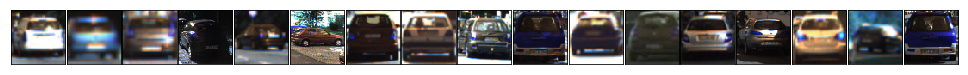

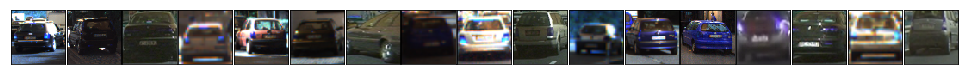

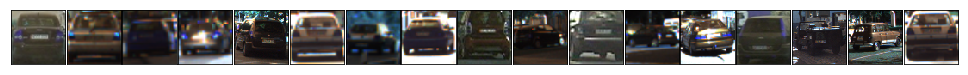

Non vechicle images: 


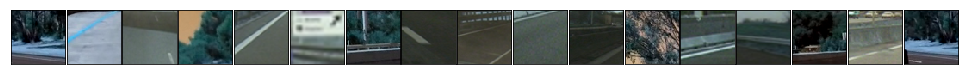

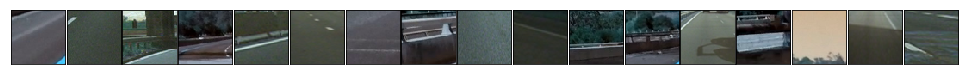

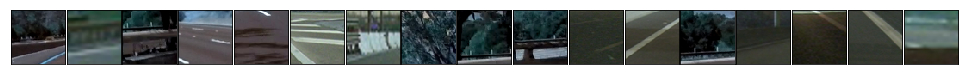

In [6]:
print("Vechicle images:")
print_examples_from_group(car_images, rows = 3)
print("Non vechicle images: ")
print_examples_from_group(non_car_images, rows = 3)

Dataset looks not so big, but may be enough for good classification. I could also apply image augmentation to improve quality of the model. Amount of non car images is almost equal to amount of car images, so I do not need to balance my train dataset.

### HOG
As the next step I want to define features that I want to extract. Firt will be converting of the image to histogram of oriented gradients (HOG), so I want to extract HOG features.
In HOG I can define following parameters:
* amount of orientations
* pixels per cell
* cells per block

For first parameter I used value 13. For second and third I need to perform some research. First of all, lets take a look on how HOG features looks like for valies 8 and 8, 8 and 2, 4 and 16, 2 and 32, 16 and 4, 32 and 2.

In [7]:
def get_hog_features(img, orient = 13, pix_per_cell = 8, cell_per_block = 2, vis = False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

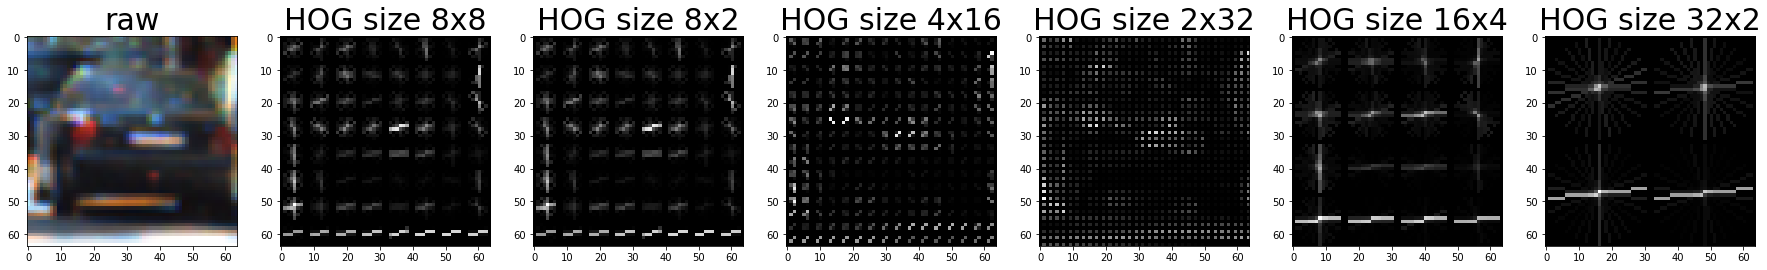

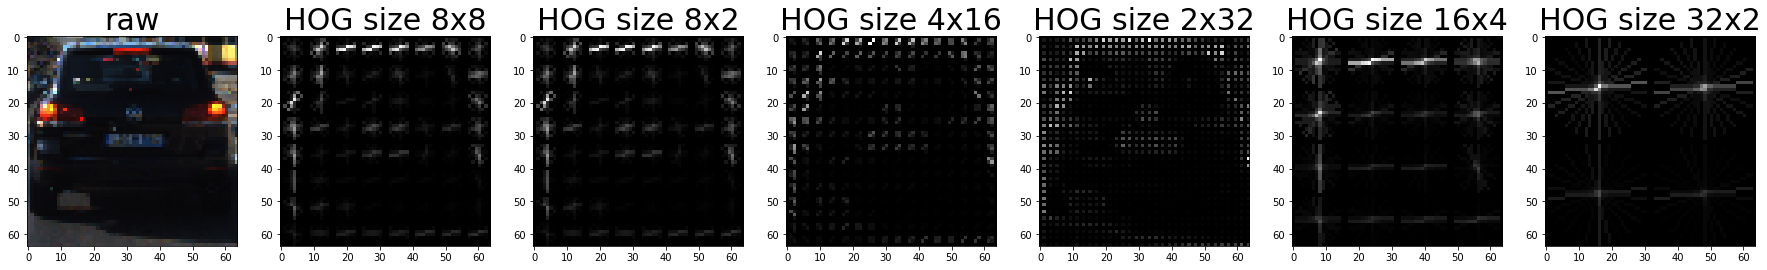

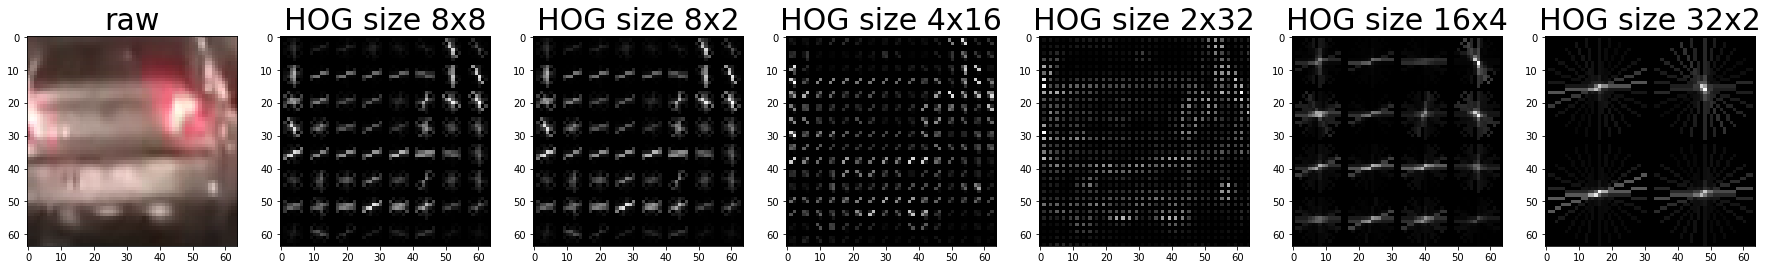

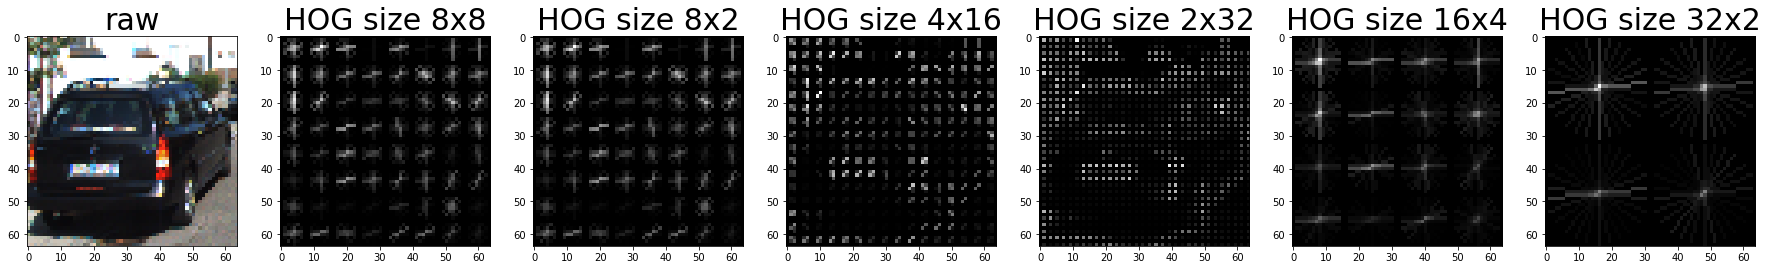

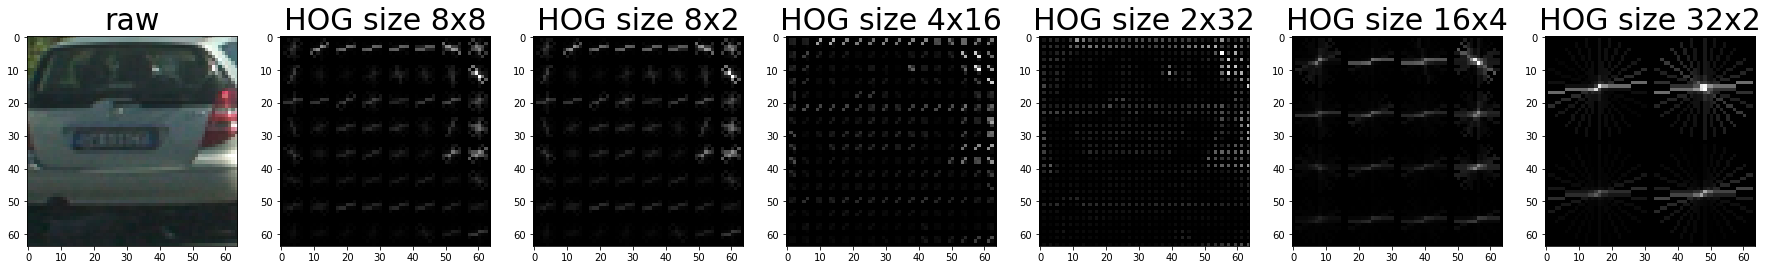

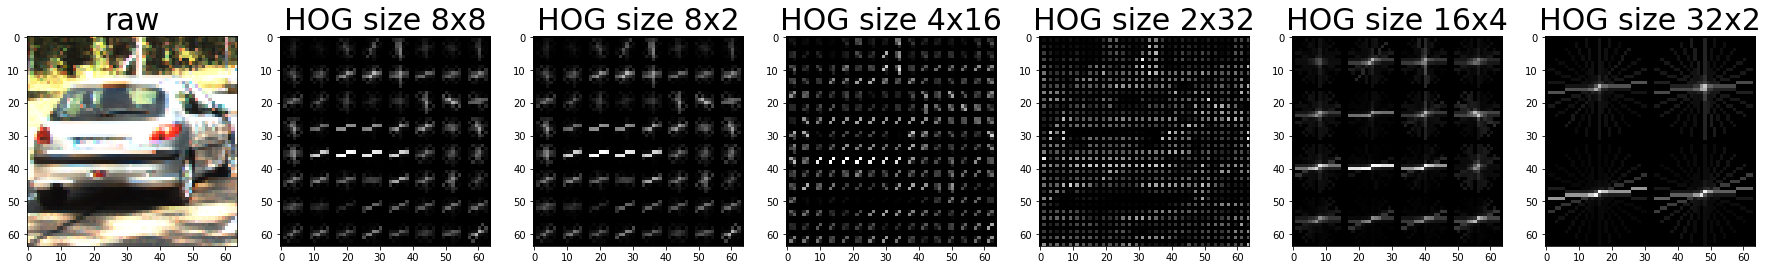

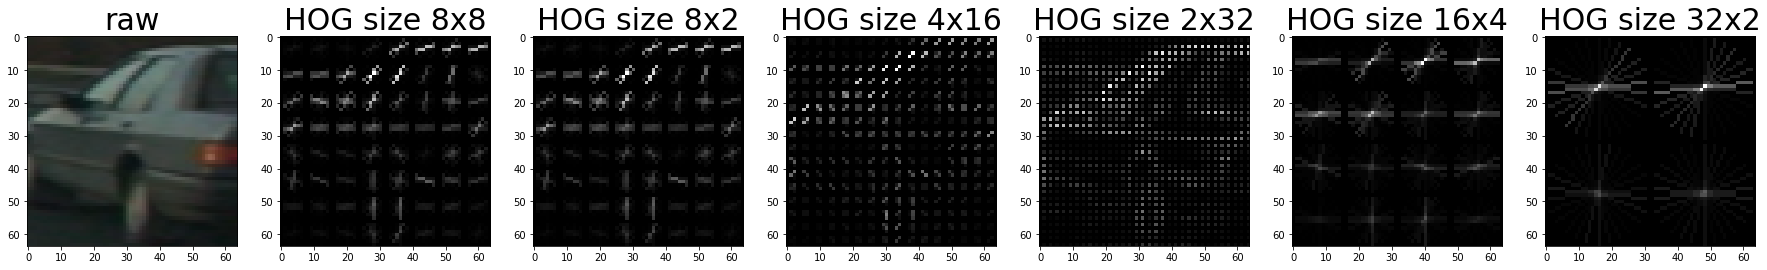

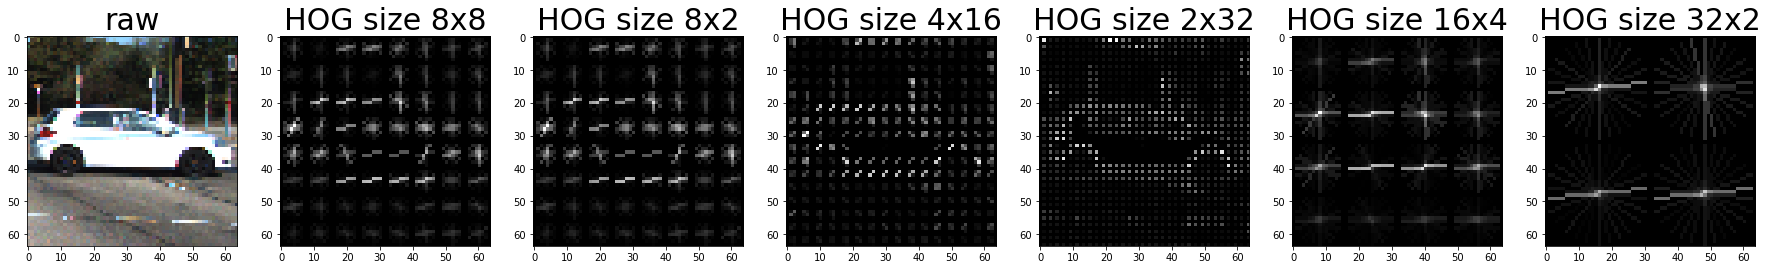

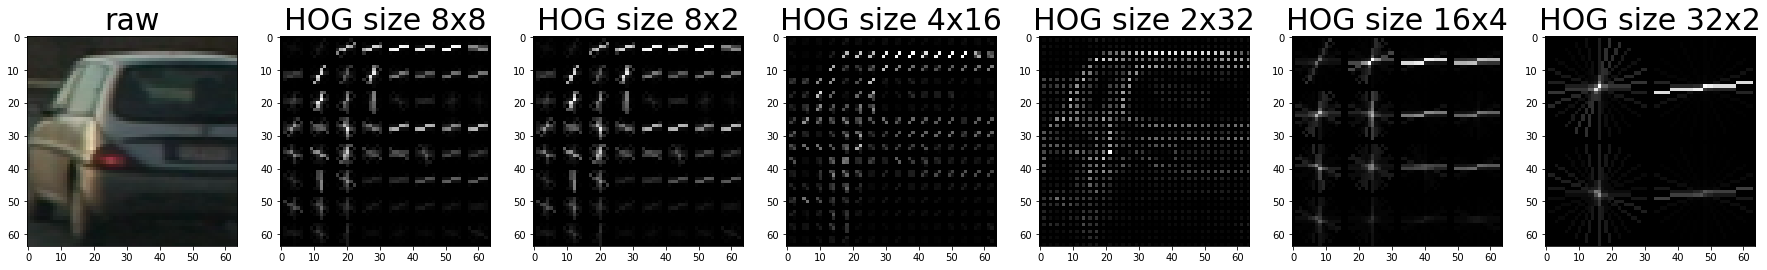

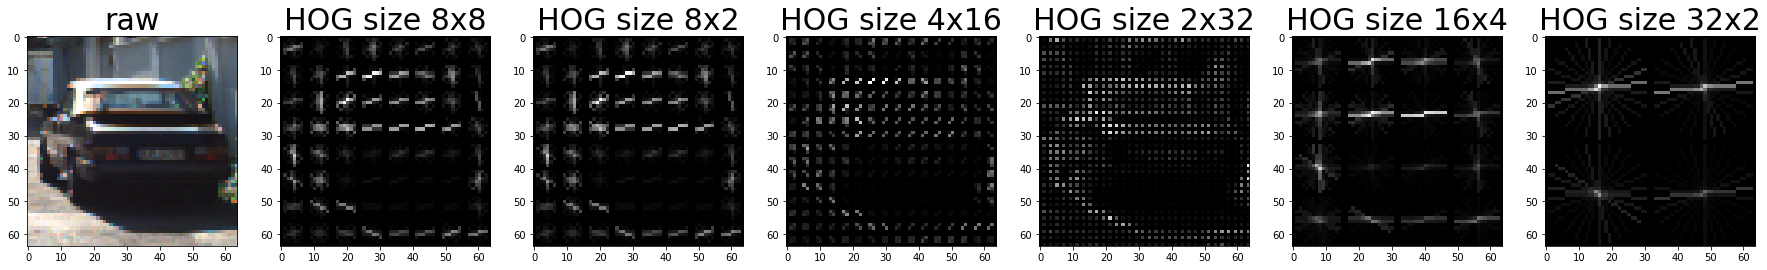

In [8]:
for i in range(10):
    index = randint(0, len(car_images) - 1)

    img = mpimg.imread(car_images[index])
    _, hog_img_8_8 = get_hog_features(img[:,:,2], pix_per_cell = 8, cell_per_block = 8, vis = True)
    _, hog_img_8_2 = get_hog_features(img[:,:,2], pix_per_cell = 8, cell_per_block = 2, vis = True)
    _, hog_img_4_16 = get_hog_features(img[:,:,2], pix_per_cell = 4, cell_per_block = 16, vis = True)
    _, hog_img_2_32 = get_hog_features(img[:,:,2], pix_per_cell = 2, cell_per_block = 32, vis = True)
    _, hog_img_16_4 = get_hog_features(img[:,:,2], pix_per_cell = 16, cell_per_block = 4, vis = True)
    _, hog_img_32_2 = get_hog_features(img[:,:,2], pix_per_cell = 32, cell_per_block = 2, vis = True)

    f, (ax1, ax2, ax21, ax3, ax4, ax5, ax6) = plt.subplots(1, 7, figsize=(24, 9))

    f.tight_layout()
    ax1.imshow(img)    
    ax1.set_title("raw", fontsize=30)

    ax2.imshow(hog_img_8_8, cmap = "gray")    
    ax2.set_title("HOG size 8x8", fontsize=30)

    ax21.imshow(hog_img_8_2, cmap = "gray")    
    ax21.set_title("HOG size 8x2", fontsize=30)

    ax3.imshow(hog_img_4_16, cmap = "gray")    
    ax3.set_title("HOG size 4x16", fontsize=30)

    ax4.imshow(hog_img_2_32, cmap = "gray")    
    ax4.set_title("HOG size 2x32", fontsize=30)

    ax5.imshow(hog_img_16_4, cmap = "gray")    
    ax5.set_title("HOG size 16x4", fontsize=30)

    ax6.imshow(hog_img_32_2, cmap = "gray")    
    ax6.set_title("HOG size 32x2", fontsize=30)

    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    # print_two_images(trans, grad, "raw", "undistorted", False, True)


Images with parameters (pixels per cell, cells per block) = (8,8), (4,16) and (2,32) looks mode precise from human point of view. (16,4) and (32, 2) looks too general from first perspective (but may be also good for detection). Images (8,8) gives good vision of the shape of the car, (4,16) and (2,32) gives more car details like car registration number bar and windows. (8,8) and (8,2) looks same on the preview.
What will be the best one? Probably, I should not select only one and can concatenate all three features. It may have sense because when we see objects with our eyes, we first extract shape of the object, similar to what we could see on image with parameters (8,8) and then look into details, that we could get from the images (4,16) and (2,32). But let the model define for us. I trained the classifier with different set of hog parameters and found that (8,2) gives me the best results. That is interesting that runinng model on (8, 8) gives much more false positive results, (8, 2) gives less false positives but is two times slower.

#### Define color channel for HOG

In the previous example I applied HOG transformation to blue channel of RGB version of the image. But it makes sence to find channels that will give more accurate feature exctraction. Lets see how different channels looks like for train images and what happens when we apply HOG to them.

cspace: RGB, channel: 0


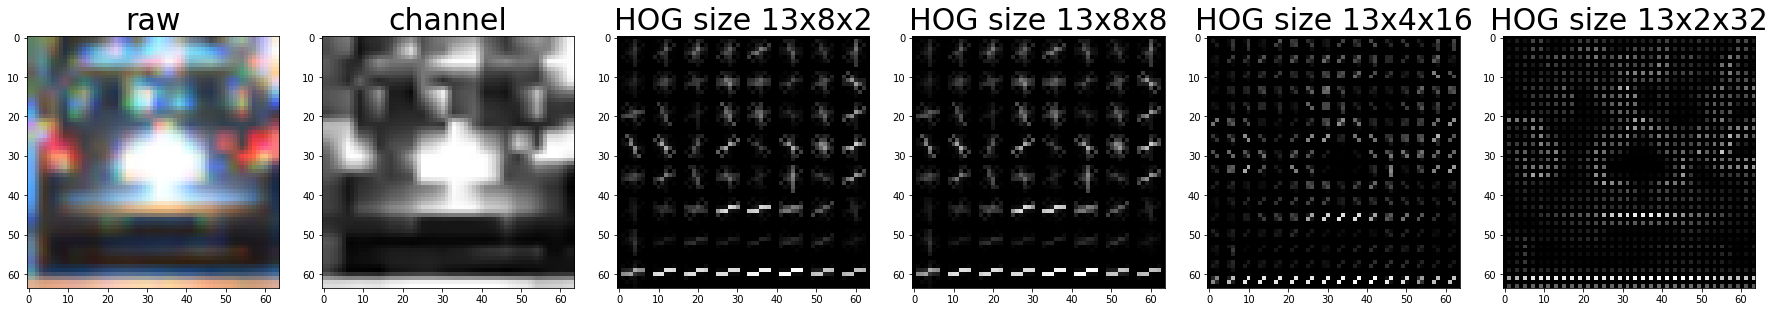

cspace: RGB, channel: 1


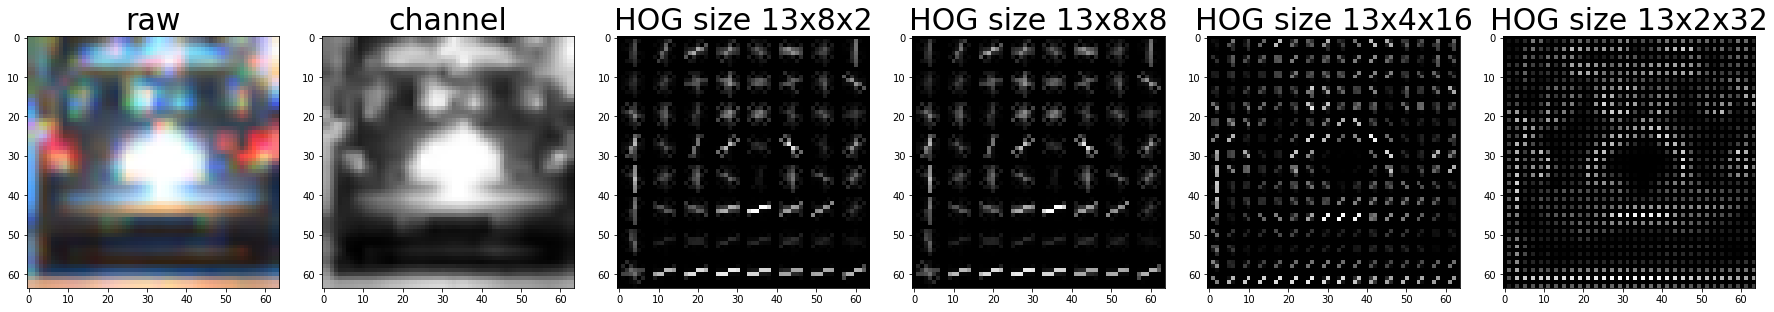

cspace: RGB, channel: 2


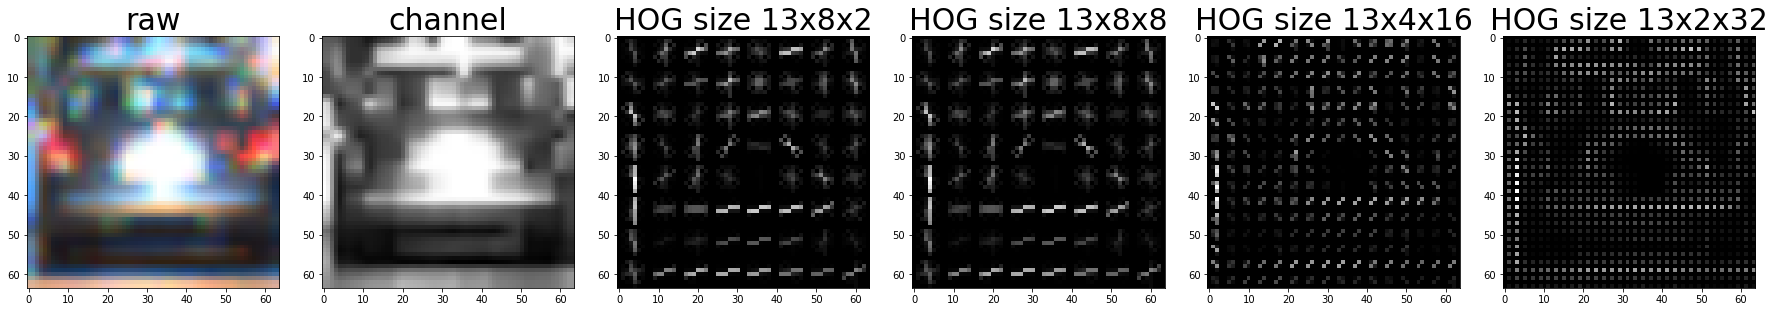

cspace: HSV, channel: 0


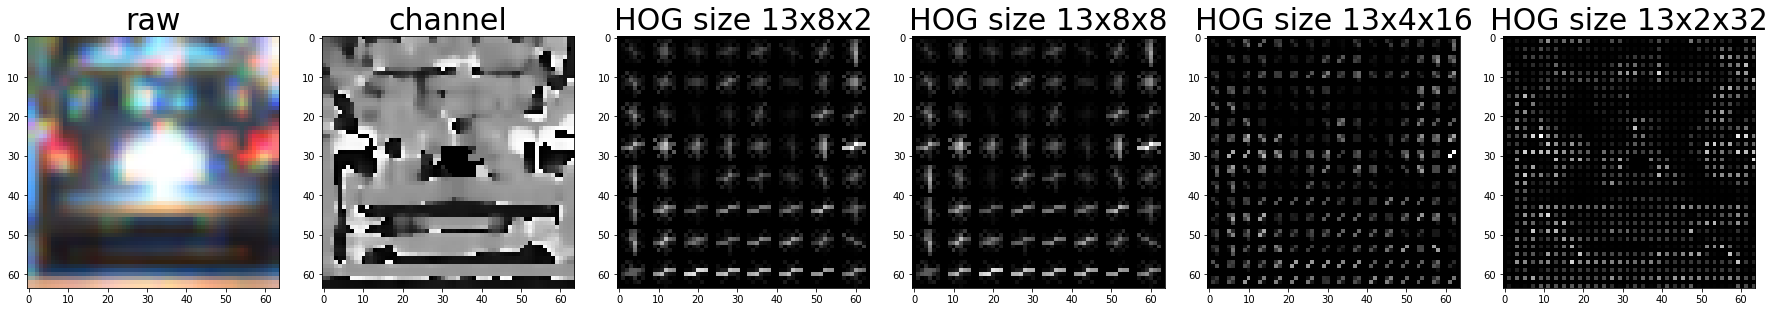

cspace: HSV, channel: 1


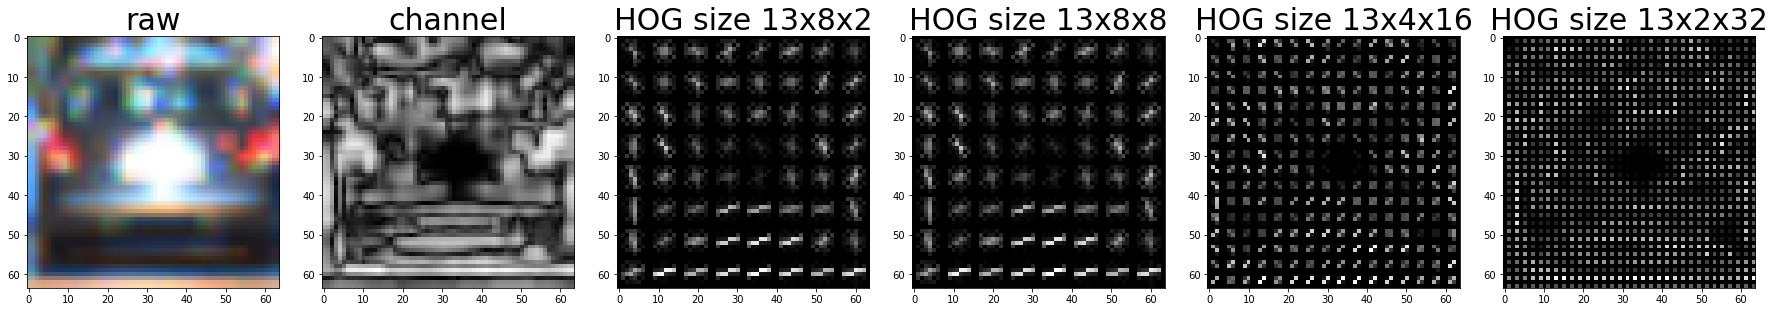

cspace: HSV, channel: 2


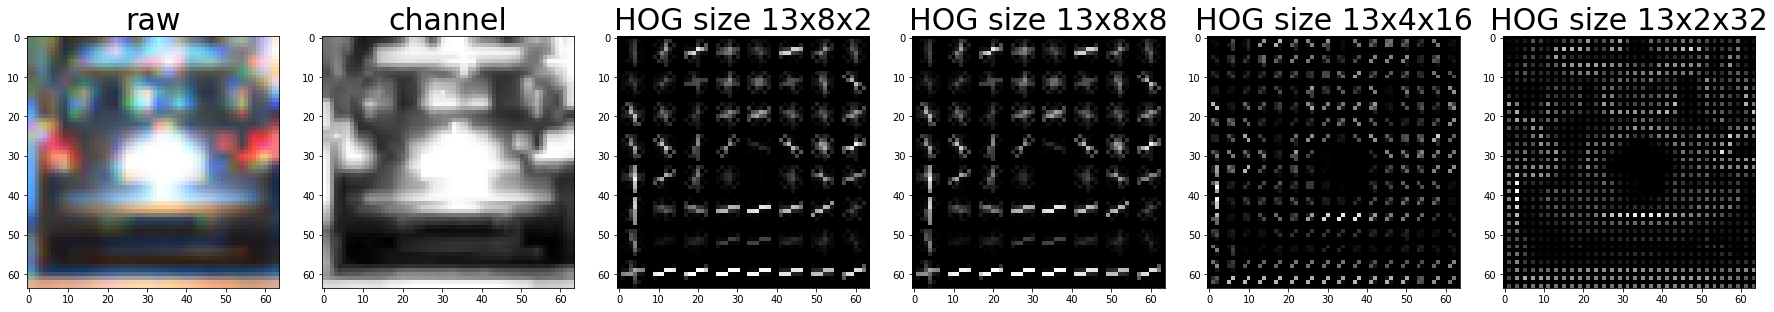

cspace: LUV, channel: 0


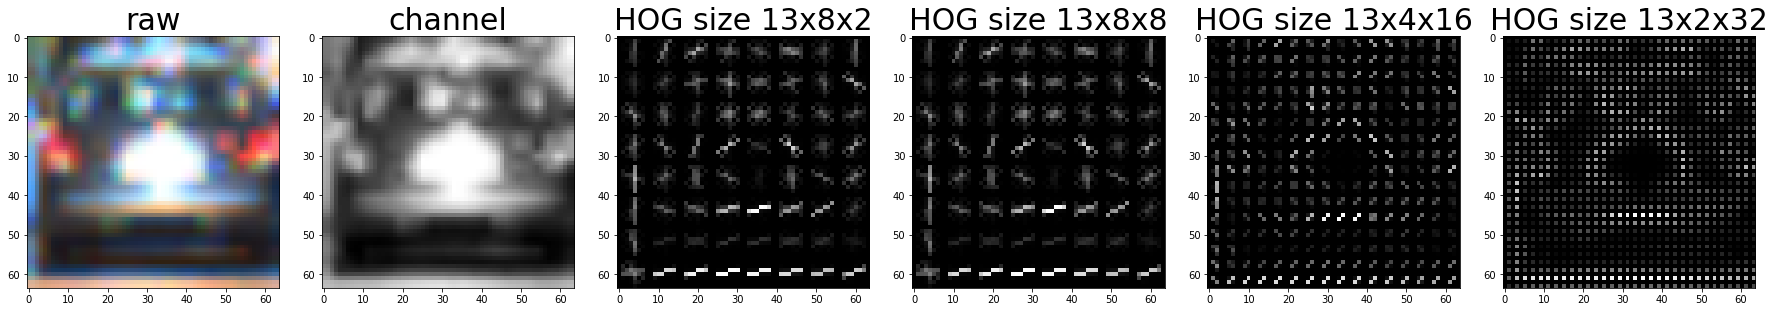

cspace: LUV, channel: 1


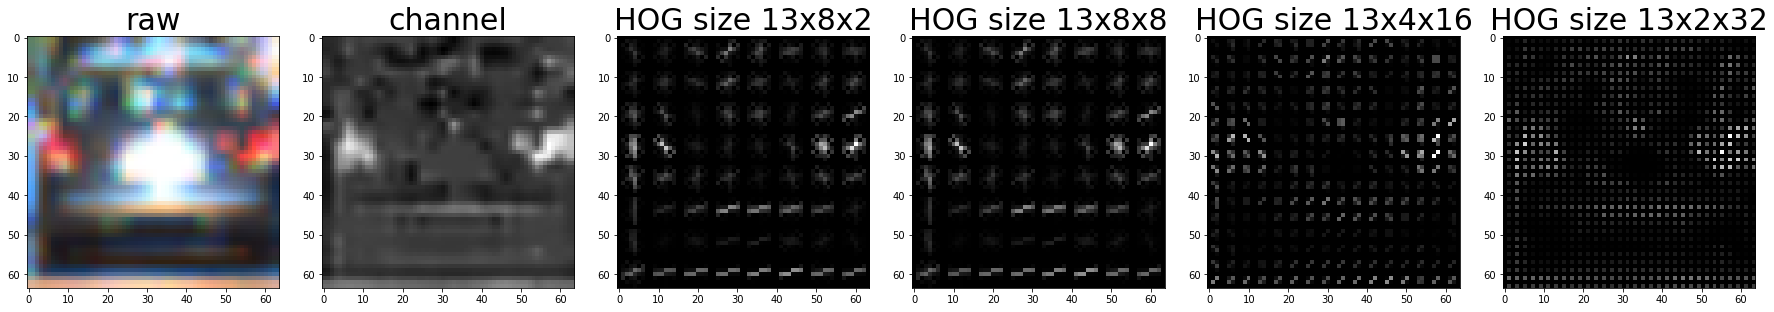

cspace: LUV, channel: 2


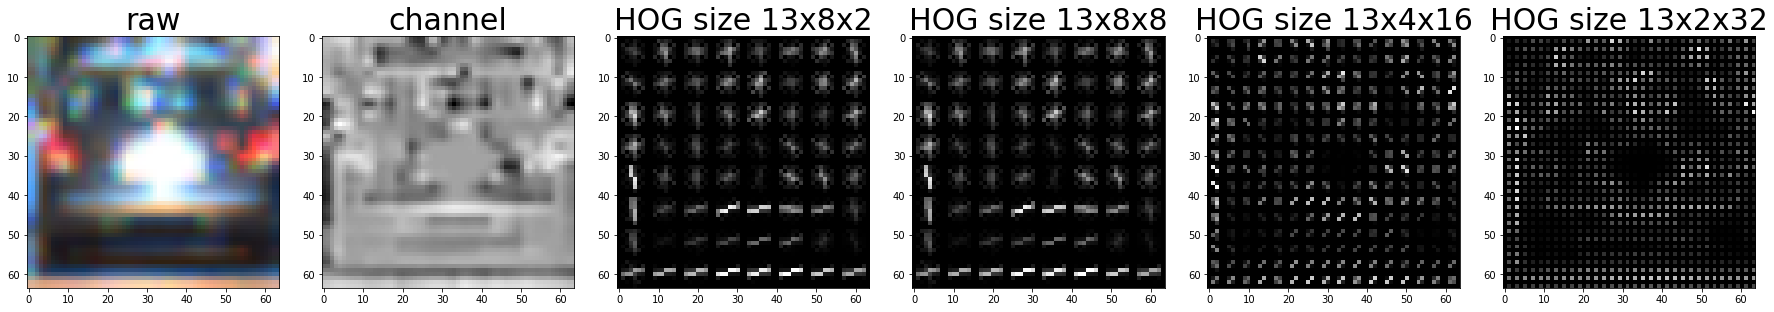

cspace: HLS, channel: 0


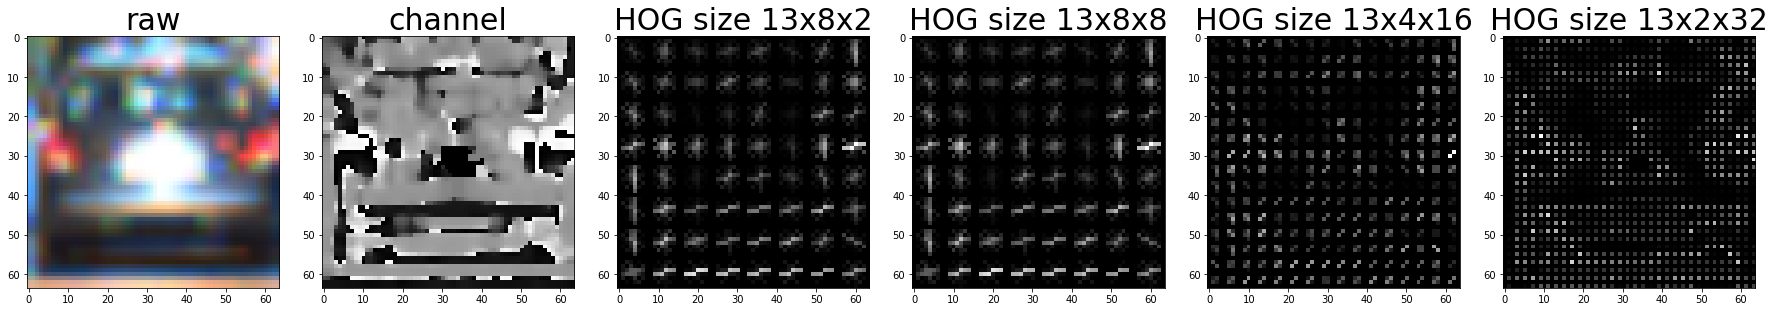

cspace: HLS, channel: 1


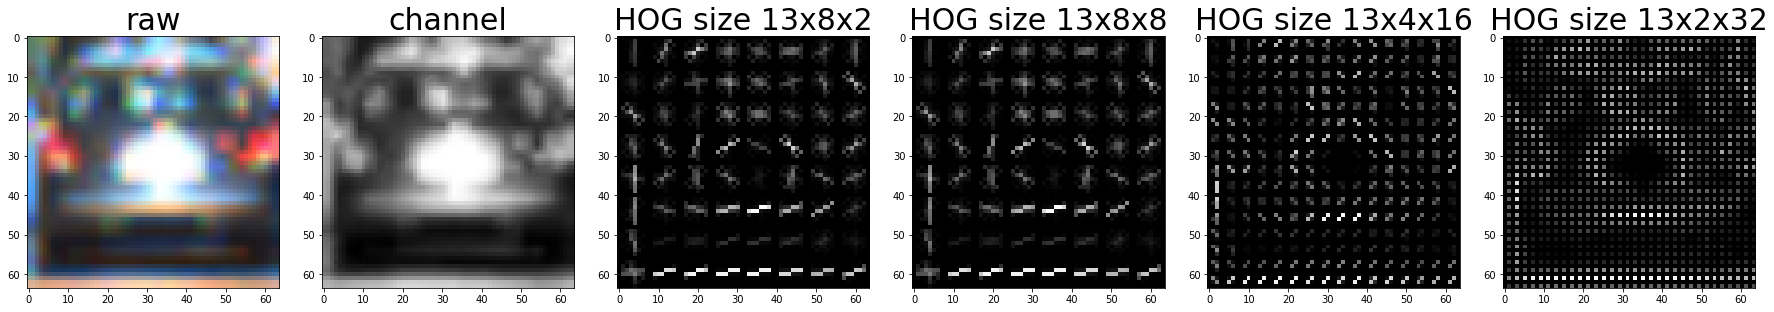

cspace: HLS, channel: 2


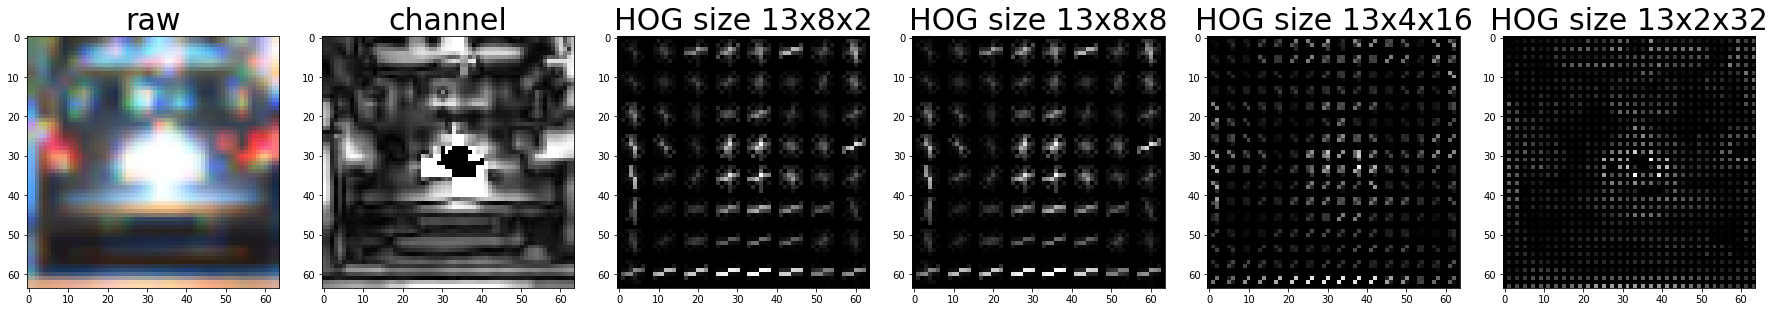

cspace: YUV, channel: 0


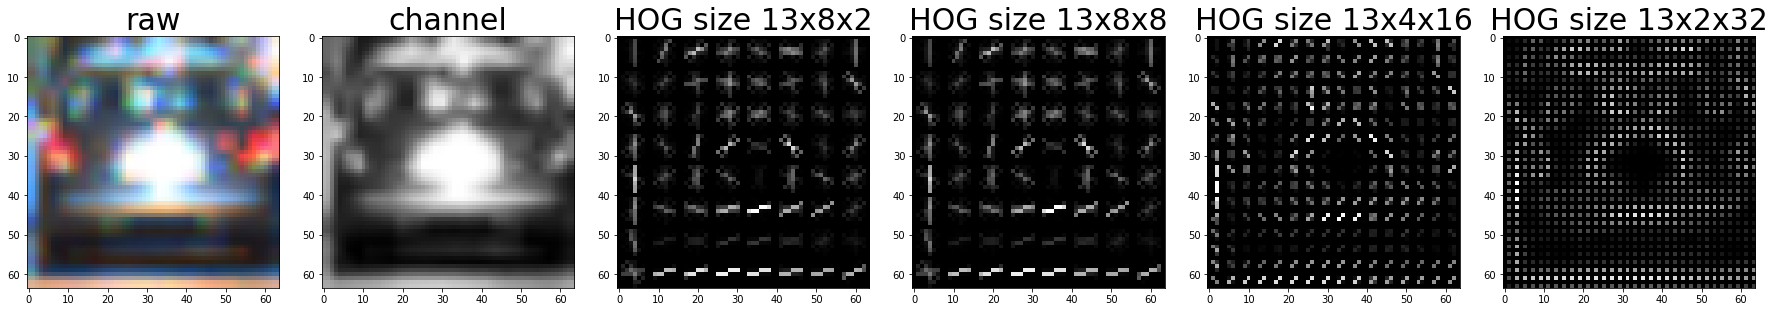

cspace: YUV, channel: 1


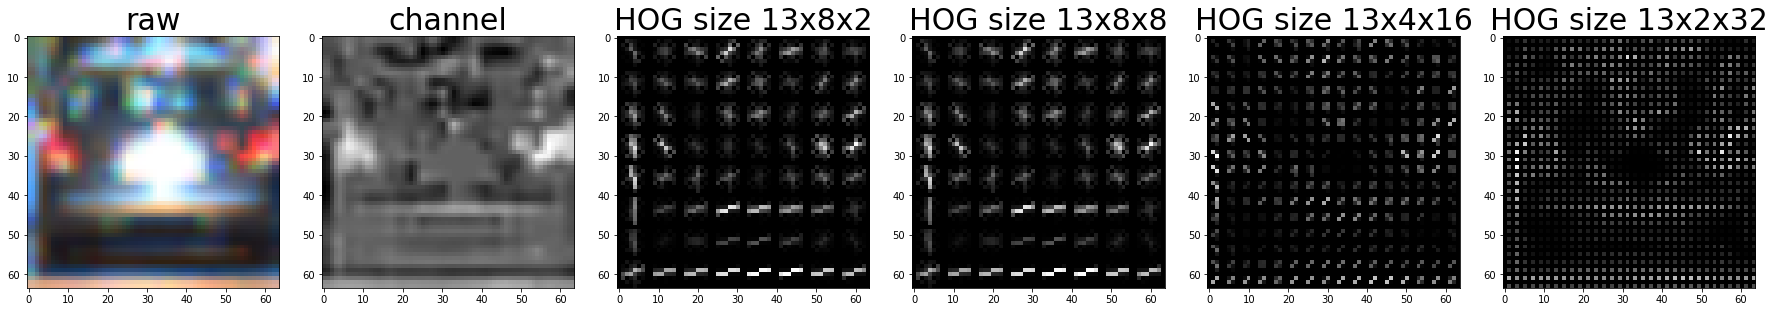

cspace: YUV, channel: 2


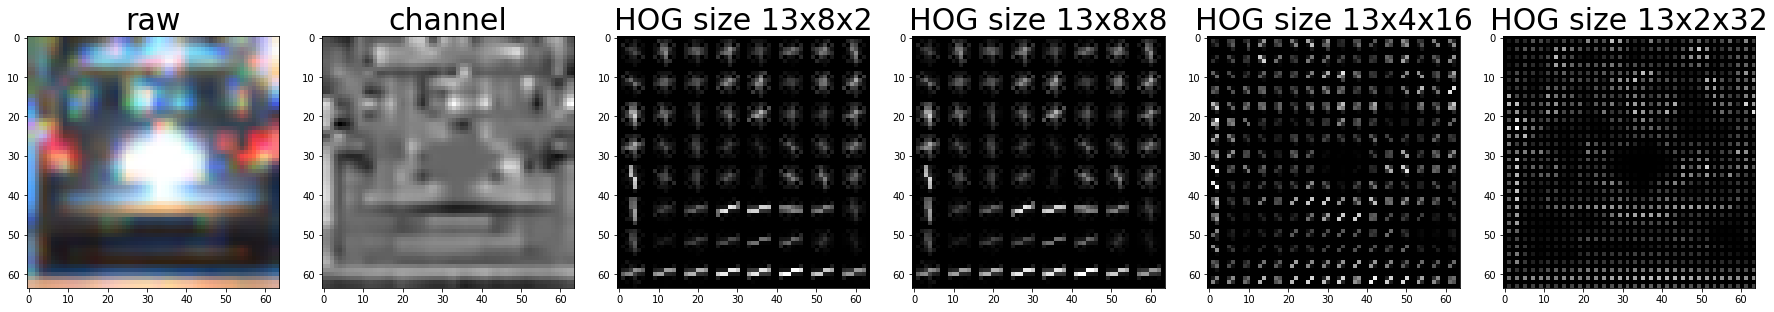

cspace: YCrCb, channel: 0


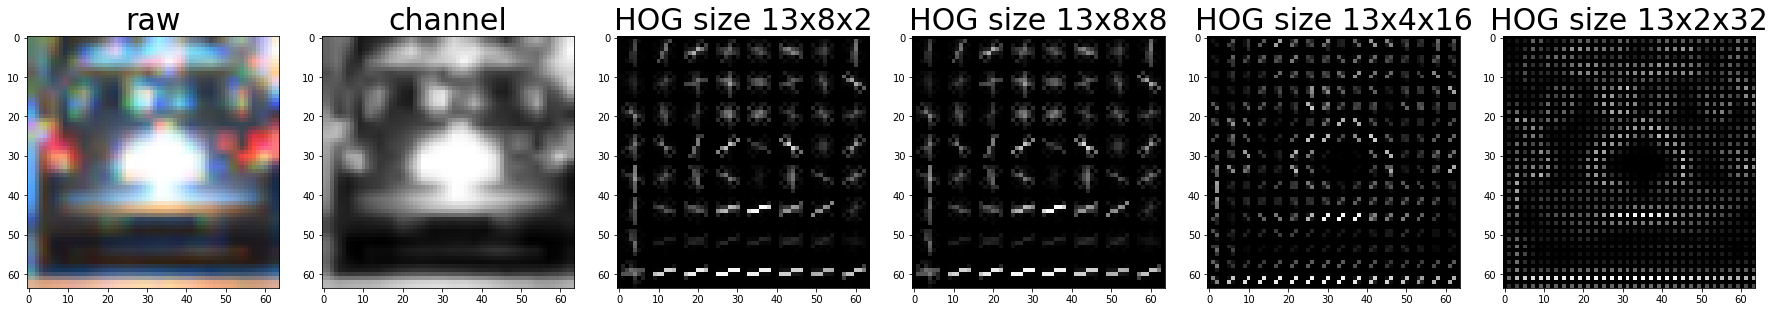

cspace: YCrCb, channel: 1


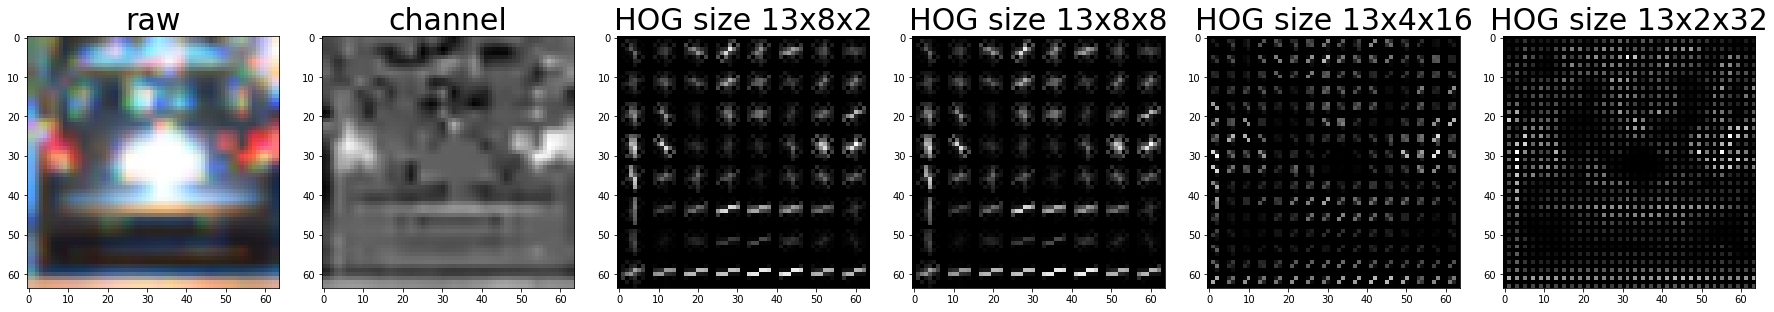

cspace: YCrCb, channel: 2


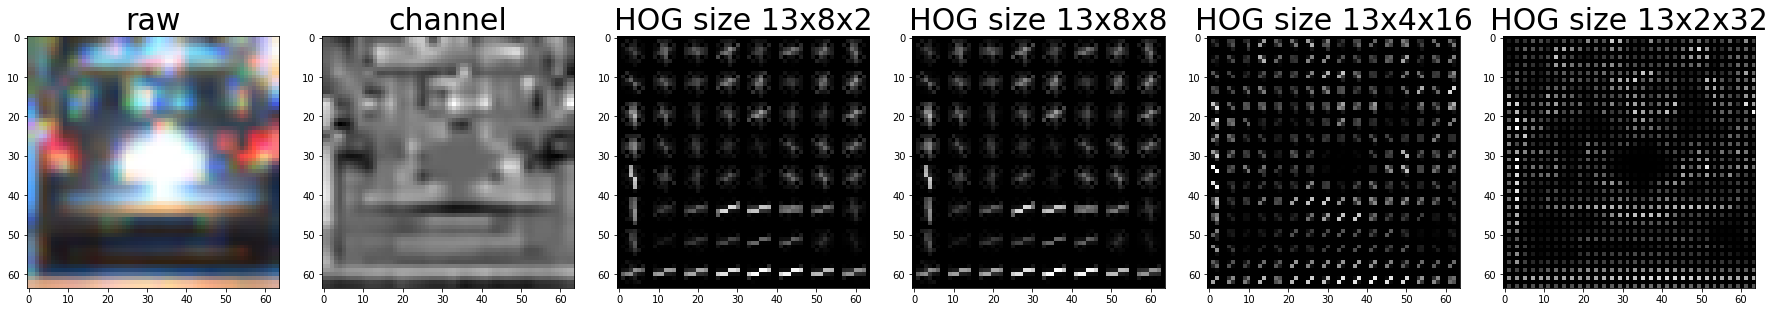

In [9]:
for i in range (1):
    index = randint(0, len(car_images) - 1)

    hog_channels = [0,1,2]
    color_spaces = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']
    for color_space in color_spaces:
        for hog_channel in hog_channels:
            img = mpimg.imread(car_images[index])
            if color_space != 'RGB':
                if color_space == 'HSV':
                    feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
                elif color_space == 'LUV':
                    feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
                elif color_space == 'HLS':
                    feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
                elif color_space == 'YUV':
                    feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
                elif color_space == 'YCrCb':
                    feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
            else: feature_image = np.copy(img)  

            _, hog_img_8_2 = get_hog_features(feature_image[:,:,hog_channel], pix_per_cell = 8, cell_per_block = 2, vis = True)
            _, hog_img_8_8 = get_hog_features(feature_image[:,:,hog_channel], pix_per_cell = 8, cell_per_block = 8, vis = True)
            _, hog_img_4_16 = get_hog_features(feature_image[:,:,hog_channel], pix_per_cell = 4, cell_per_block = 16, vis = True)
            _, hog_img_2_32 = get_hog_features(feature_image[:,:,hog_channel], pix_per_cell = 2, cell_per_block = 32, vis = True)

            f, (ax1, ax12, ax13, ax2, ax3, ax4) = plt.subplots(1, 6, figsize=(24, 9))

            f.tight_layout()
            print("cspace: {0}, channel: {1}".format(color_space, hog_channel))
            ax1.imshow(img)    
            ax1.set_title("raw", fontsize=30)

            ax12.imshow(feature_image[:,:,hog_channel], cmap = "gray")    
            ax12.set_title("channel", fontsize=30)

            ax13.imshow(hog_img_8_2, cmap = "gray")    
            ax13.set_title("HOG size 13x8x2", fontsize=30)

            ax2.imshow(hog_img_8_8, cmap = "gray")    
            ax2.set_title("HOG size 13x8x8", fontsize=30)

            ax3.imshow(hog_img_4_16, cmap = "gray")    
            ax3.set_title("HOG size 13x4x16", fontsize=30)

            ax4.imshow(hog_img_2_32, cmap = "gray")    
            ax4.set_title("HOG size 13x2x32", fontsize=30)

            plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
            plt.show()

We can clearly see that on some channels car image is better recognisable and on some worse. But this recognition is made by human, what will our classifier say about it? Lets give it a try!

### More features

I defined a function to compute binned color features and a function to compute color histogram features. I want to see if this features will help me with my model. After test runs I decided not to use it in my pipeline.

In [10]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
def color_hist(img, nbins=32, bins_range=(0, 1)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


### Test the model!
So, now we can test classifier in different colour spaces, with different HOG parameters and with different set of features.

In [11]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()

# hog_parameters = [[orient, pix_per_cell, cell_per_block],...]
def extract_features(imgs, color_space='HLS', spatial_size=(32, 32),
                        hist_bins=32, hog_channel=0,
                        spatial_feat=False, hist_feat=False, hog_feat=True, hog_parameters = [[13, 8, 2]]):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:                 
            for hog_parameter in hog_parameters:
                if hog_channel == 'ALL':
                    hog_features = []
                    for channel in range(feature_image.shape[2]):
                        hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                            hog_parameter[0], hog_parameter[1], hog_parameter[2], 
                                            vis=False, feature_vec=True))
                    hog_features = np.ravel(hog_features)        
                else:
                    hog_features = get_hog_features(feature_image[:,:,hog_channel], hog_parameter[0], 
                                hog_parameter[1], hog_parameter[2], vis=False, feature_vec=True)
                # Append the new feature vector to the features list
                file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [12]:
hog_channels = [0,1,2,'ALL']
#hog_channels = ['ALL']
color_spaces = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']
#color_spaces = ['YCrCb']
for color_space in color_spaces:
    for hog_channel in hog_channels:
        car_features = extract_features(car_images, color_space=color_space, hog_parameters = [[13, 8, 2]],
                                hog_channel=hog_channel,spatial_feat=False, hist_feat=False)
        non_car_features = extract_features(non_car_images, color_space=color_space, hog_parameters = [[13, 8, 2]],
                                hog_channel=hog_channel,spatial_feat=False, hist_feat=False)

        X = np.vstack((car_features, non_car_features)).astype(np.float64)  
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))

        X_scaler = StandardScaler().fit(X) 
        scaled_X = X_scaler.transform(X)

        X_train, y_train = shuffle(scaled_X, y)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

        # Use a linear SVC 
        classifier = LinearSVC()
        # Check the training time for the SVC
        classifier.fit(X_train, y_train)
        # Check the score of the SVC
        print('Test SVC with HOG {0} in Color Space {1} = '.format(hog_channel, color_space), 
              round(classifier.score(X_test, y_test), 4))

Test SVC with HOG 0 in Color Space RGB =  0.9532
Test SVC with HOG 1 in Color Space RGB =  0.9643
Test SVC with HOG 2 in Color Space RGB =  0.9623
Test SVC with HOG ALL in Color Space RGB =  0.9726
Test SVC with HOG 0 in Color Space HSV =  0.9324
Test SVC with HOG 1 in Color Space HSV =  0.9088
Test SVC with HOG 2 in Color Space HSV =  0.9625
Test SVC with HOG ALL in Color Space HSV =  0.9814
Test SVC with HOG 0 in Color Space LUV =  0.9602
Test SVC with HOG 1 in Color Space LUV =  0.9398
Test SVC with HOG 2 in Color Space LUV =  0.9187
Test SVC with HOG ALL in Color Space LUV =  0.9796
Test SVC with HOG 0 in Color Space HLS =  0.928
Test SVC with HOG 1 in Color Space HLS =  0.9581
Test SVC with HOG 2 in Color Space HLS =  0.902
Test SVC with HOG ALL in Color Space HLS =  0.9783
Test SVC with HOG 0 in Color Space YUV =  0.9595
Test SVC with HOG 1 in Color Space YUV =  0.9453
Test SVC with HOG 2 in Color Space YUV =  0.9232
Test SVC with HOG ALL in Color Space YUV =  0.9834
Test SVC wit

In [13]:
# Feature extraction parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
hog_parameters = [[13,8,2]]

car_features = extract_features(car_images, color_space=color_space, hog_parameters=hog_parameters,
                        hog_channel=hog_channel,spatial_feat=False, hist_feat=False)
non_car_features = extract_features(non_car_images, color_space=color_space,hog_parameters=hog_parameters, 
                        hog_channel=hog_channel,spatial_feat=False, hist_feat=False)

X = np.vstack((car_features, non_car_features)).astype(np.float64)  
y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))

X_scaler = StandardScaler().fit(X) 
scaled_X = X_scaler.transform(X)

X_train, y_train = shuffle(scaled_X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)


for c in range(1, 50, 5):
    # Use a linear SVC 
    classifier = LinearSVC(C = c)
    # Check the training time for the SVC
    classifier.fit(X_train, y_train)
    # Check the score of the SVC
    print('Test accuracy for SVC with C {0} = '.format(c), 
          round(classifier.score(X_test, y_test), 4))

Test accuracy for SVC with C 1 =  0.9822
Test accuracy for SVC with C 6 =  0.9811
Test accuracy for SVC with C 11 =  0.981
Test accuracy for SVC with C 16 =  0.9807
Test accuracy for SVC with C 21 =  0.9807
Test accuracy for SVC with C 26 =  0.9807
Test accuracy for SVC with C 31 =  0.9807
Test accuracy for SVC with C 36 =  0.9807
Test accuracy for SVC with C 41 =  0.9807
Test accuracy for SVC with C 46 =  0.9807


After numerous amount of runs with different parameters I got best results with following parameters:
1. use only HOG features, do not perform histogram and binned colour features
2. do in YCrCb color space with all channels
3. use (orient, pix_per_cell, cell_per_block) = (13,8,2) HOG parameters
4. parameter C of SupportSVC function can be zero (default)

So now I can start with building my pipeline.

# Pipeline
### 1. Train classifier 
Train classifier. Use LinearSVC from sklearn. I applied StandardScaler method from sklearn to normalize features.

In [14]:
color_space = 'YCrCb' 
hog_channel = 'ALL'
#hog_parameters = [[8,8], [4,16]]
hog_parameters = [[13, 8, 2]]

car_features = extract_features(car_images, color_space=color_space, hog_channel=hog_channel,
                        spatial_feat=False, hist_feat=False, hog_feat=True, hog_parameters = hog_parameters)
non_car_features = extract_features(non_car_images, color_space=color_space, hog_channel=hog_channel,
                        spatial_feat=False, hist_feat=False, hog_feat=True, hog_parameters = hog_parameters)

X = np.vstack((car_features, non_car_features)).astype(np.float64)  
y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))


#print(X.shape)
X_scaler = StandardScaler().fit(X) 
scaled_X = X_scaler.transform(X)

X_train, y_train = shuffle(scaled_X, y)

# Use a linear SVC 
classifier = LinearSVC() 
# Train classifier. I do not use test set in this function because I have fixed parameters in the pipeline.
classifier.fit(X_train, y_train) 

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

### 2. Implement sliding window
In order to detect car on the image I implement sliding window function that takes image, size of the window border in pixels, step overlay (step size is window width devided by step overlay), y thresholds (so for smaller windows I can search more in center of the image, when for bigger search in bigger area). I use all width of the image, so I do not need any x thresholds.

In [15]:
def sliding_window(ymin, ymax, window_border, step_overlay, channels, model, hog_parameters, print_all = False):    
    res = []

    channel = channels[0]
    ch_cropped = channel[ymin:ymax,:]

    # calculate amount of boxes for siding window
    step_size = round(window_border / step_overlay)
    nxblocks = round(ch_cropped.shape[1] / step_size) - step_overlay + 1
    nyblocks = round(ch_cropped.shape[0] / step_size) - step_overlay + 1  

    # iterate over all boxes and predict if it is a car 
    for x_step in range(nxblocks):
        for y_step in range(nyblocks):
            ym = y_step*step_size
            xm = x_step*step_size
            features = []
            stacked_features = []
               
            # iterate over all parameters and extract features 
            for hog_parameter in hog_parameters:
                for channel in channels:
                    ch_cropped = np.copy(channel)
                    ch_cropped = ch_cropped[ymin:ymax,:]

                    window_image = ch_cropped[ym:ym+window_border,xm:xm+window_border]
                    window_resized = cv2.resize(window_image, (64,64))
                    window_features = get_hog_features(window_resized, hog_parameter[0], hog_parameter[1], 
                                                       hog_parameter[2], vis=False, feature_vec=True)
                    stacked_features.append(window_features) 
                    
            stacked_features = np.concatenate(stacked_features).reshape(-1, 1)
            features.append(stacked_features) 
            features = np.array(features).astype(np.float64)
            
            # normalize data 
            X_scaler = StandardScaler().fit(stacked_features) 
            scaled_stacked_features = X_scaler.transform(stacked_features)
            
            # predict if it is a car
            prediction = model.predict(np.concatenate(scaled_stacked_features).reshape(1, -1))
            
            if prediction == 1 or print_all:
                res.append(((xm, ym + ymin),(xm + window_border,ym + window_border + ymin)))
                
    return res         

### 3. Define class for keeping predictions
Define class for keeping rectangles with predicted images. I use it during video processing to reduce amount of false positives. 

In [16]:
# Class for keeping rectangles during video processing over several frames 
class Predictions():
    stack = np.empty([0])
    stack_size = 6
    box_sizes = []
            
    def add_boxes(self, boxes):
        #print(self.stack.shape)
        #print(len(boxes))
        if len(boxes) > 0: 
            if self.stack.shape[0] == 0:
                self.stack = np.array(boxes)
            else:
                self.stack = np.concatenate((self.stack, np.array(boxes)))
            
        #print("Input boxes: ",np.array(boxes).shape)
        #print("Current boxes state: ", self.box_sizes)    
        #print("Stack before resize: ", self.stack.shape) 
        self.box_sizes.append(np.array(boxes).shape[0])
        current_stack_length = len(self.box_sizes)

        if current_stack_length > self.stack_size:
            self.stack = self.stack[self.box_sizes[0]:]
            self.box_sizes = self.box_sizes[1:]
        #print("Stack after resize: ", self.stack.shape)
            
            
    def get_boxes(self):
        return self.stack
    
    def reset(self):
        self.stack = np.empty([0])
        self.stack_size = 6
        self.box_sizes = []
    
predictions = Predictions()

### 4. Get positions of the car on the image
Then I defined main functions to get positions of the car on the image. It containes following steps:
1. Apply general y thresholds for faster work. All following thresholds will be applied inside cropped image.
2. Convert image to YCrCb color space.
3. Call window functions for all channels with several sizes. I used 6 sizes with different y thresholds and step overlays (look into the code for details).
4. Apply y offset to all found rectangles, so I get correct y values for non cropped image.
5. Add found rectangles to stack (to average over several video frames and filter out false positives)
6. Create heatmap from stack of rectangles
7. Calculate labels from heatmap and draw all that has > than X (I used 50 - 60) intersects of different rectangles in order to exclude false positives.

In [17]:
# draw rectangle on the image
def draw_rectangles(img, rectangles, color):
    res = np.copy(img)
    for rectangle in rectangles:
        cv2.rectangle(res, rectangle[0], rectangle[1], color, 6)
        
    return res

# apply y offset to rectangles, used after image cropping
def shift_rectangles(rectangles, y_offset):
    shifted_rectangles = []
    for rectangle in rectangles:
        ypred0 = rectangle[0][1] + y_offset
        xpred0 = rectangle[0][0]
        ypred1 = rectangle[1][1] + y_offset
        xpred1 = rectangle[1][0]
        shifted_rectangles.append(((xpred0, ypred0),(xpred1, ypred1)))
        
    return shifted_rectangles

# apply heatmap
def get_heatmap(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        #print(box)
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap    

# draw labeled boxes on the image
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        
    # Return the image and final rectangles
    return img, rects

# main processing logic
def predict_car_positions(img, heatmap_threshold = 6):  
    ymin = 350
    ymax = 720
    #hog_parameters = [[13, 8, 8],[13, 4, 16]]
    hog_parameters = [[13, 8, 2]]
    img_cropped = img[ymin:ymax,:,:]
    
    # scale the image
    # img_scaled = img_cropped.astype(np.float32)/255
    
    img_cspace = cv2.cvtColor(img_cropped, cv2.COLOR_RGB2YCrCb)
    
    ch1 = img_cspace[:,:,0]
    ch2 = img_cspace[:,:,1]
    ch3 = img_cspace[:,:,2]

    #predictions00 = sliding_window(ymin = 0, ymax = 200, window_border = 30, step_overlay = 3, 
    #                          channels = [ch1, ch2, ch3], model = classifier, 
    #                          hog_parameters = hog_parameters, print_all = False)
        
    predictions0 = sliding_window(ymin = 0, ymax = 200, window_border = 50, step_overlay = 3, 
                                  channels = [ch1, ch2, ch3], model = classifier, 
                                  hog_parameters = hog_parameters, print_all = False)
    
    predictions1 = sliding_window(ymin = 0, ymax = 200, window_border = 64, step_overlay = 3, 
                                  channels = [ch1, ch2, ch3], model = classifier, 
                                  hog_parameters = hog_parameters, print_all = False)
    
    predictions2 = sliding_window(ymin = 0, ymax = 230, window_border = 90, step_overlay = 4, 
                                  channels = [ch1, ch2, ch3], model = classifier, 
                                  hog_parameters = hog_parameters, print_all = False)
    
    predictions3 = sliding_window(ymin = 0, ymax = 260, window_border = 120, step_overlay = 4, 
                                 channels = [ch1, ch2, ch3], model = classifier, 
                                  hog_parameters = hog_parameters, print_all = False)
    
    predictions4 = sliding_window(ymin = 0, ymax = 300, window_border = 150, step_overlay = 5, 
                                 channels = [ch1, ch2, ch3], model = classifier, 
                                  hog_parameters = hog_parameters, print_all = False)
    
    predictions5 = sliding_window(ymin = 0, ymax = 350, window_border = 180, step_overlay = 6, 
                                 channels = [ch1, ch2, ch3], model = classifier, 
                                  hog_parameters = hog_parameters, print_all = False)
    
    #predictions00 = shift_rectangles(predictions00, ymin)
    predictions0 = shift_rectangles(predictions0, ymin)
    predictions1 = shift_rectangles(predictions1, ymin)
    predictions2 = shift_rectangles(predictions2, ymin)
    predictions3 = shift_rectangles(predictions3, ymin)
    predictions4 = shift_rectangles(predictions4, ymin)
    predictions5 = shift_rectangles(predictions5, ymin)
        
    img_rect = np.copy(img)
    
    #img_rect = print_rectangles(img_rect, predictions00, (255, 255, 255))
    img_rect = draw_rectangles(img_rect, predictions0, (255, 255, 0))
    img_rect = draw_rectangles(img_rect, predictions1, (0, 0, 255))
    img_rect = draw_rectangles(img_rect, predictions2, (255, 0, 0))
    img_rect = draw_rectangles(img_rect, predictions3, (0, 255, 0))
    img_rect = draw_rectangles(img_rect, predictions4, (0, 255, 255))
    img_rect = draw_rectangles(img_rect, predictions5, (255, 0, 255))

    #predictions.add_boxes(predictions00)
    predictions.add_boxes(predictions0)
    predictions.add_boxes(predictions1)
    predictions.add_boxes(predictions2)
    predictions.add_boxes(predictions3)
    predictions.add_boxes(predictions4)
    predictions.add_boxes(predictions5)

    predictions_sum = predictions.get_boxes()
    # print(predictions_sum.shape)
    
    img_heatmap = np.zeros_like(img[:,:,0])
    img_heatmap = get_heatmap(img_heatmap, predictions_sum)
              
    img_heatmap_th = np.copy(img_heatmap)
    img_heatmap_th[img_heatmap_th <= heatmap_threshold] = 0
    
    labels = label(img_heatmap_th)
    
    res_img, _ = draw_labeled_bboxes(img, labels)
    
    return img_rect, img_heatmap, res_img

### 4. Run on test images

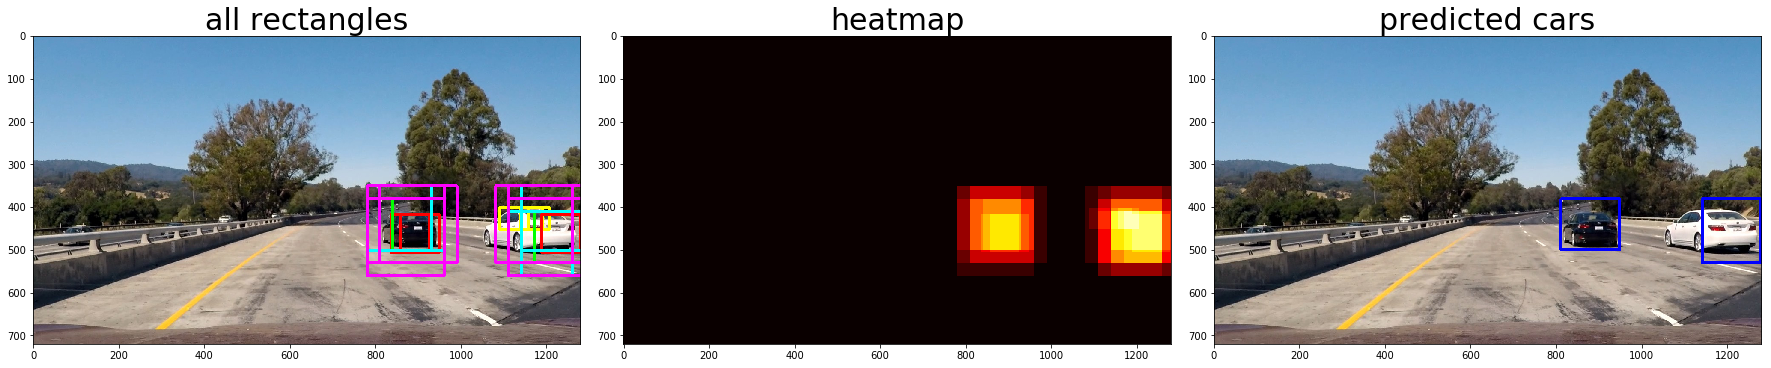

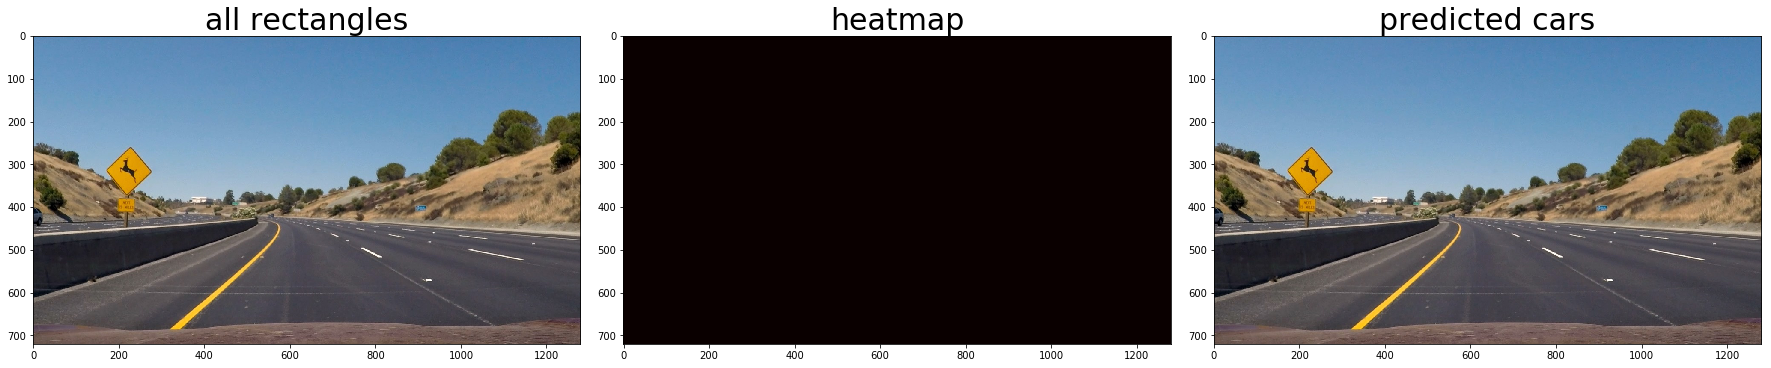

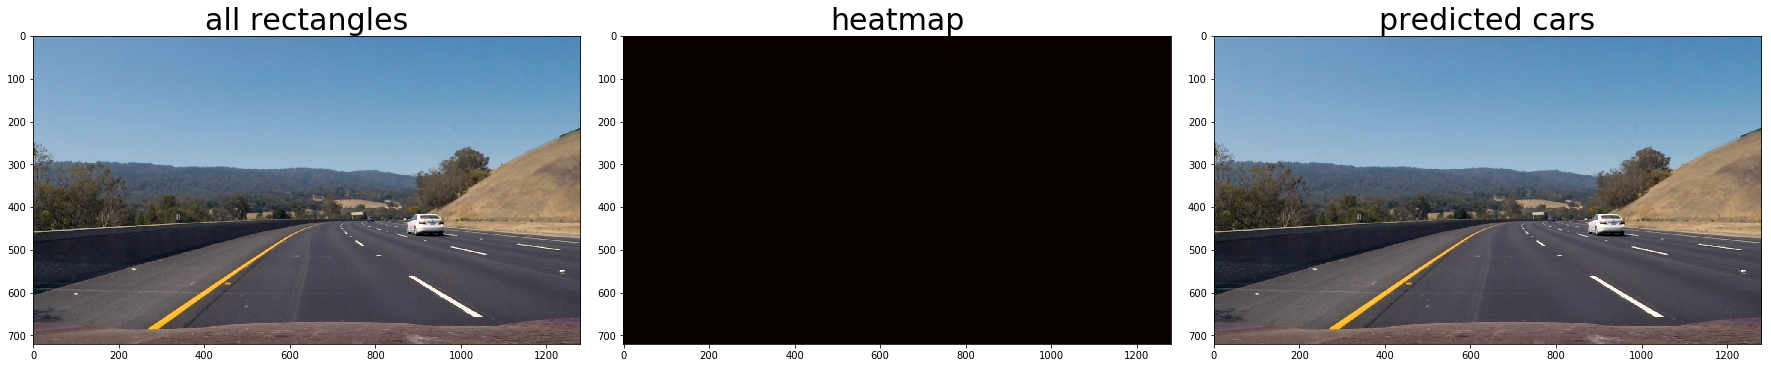

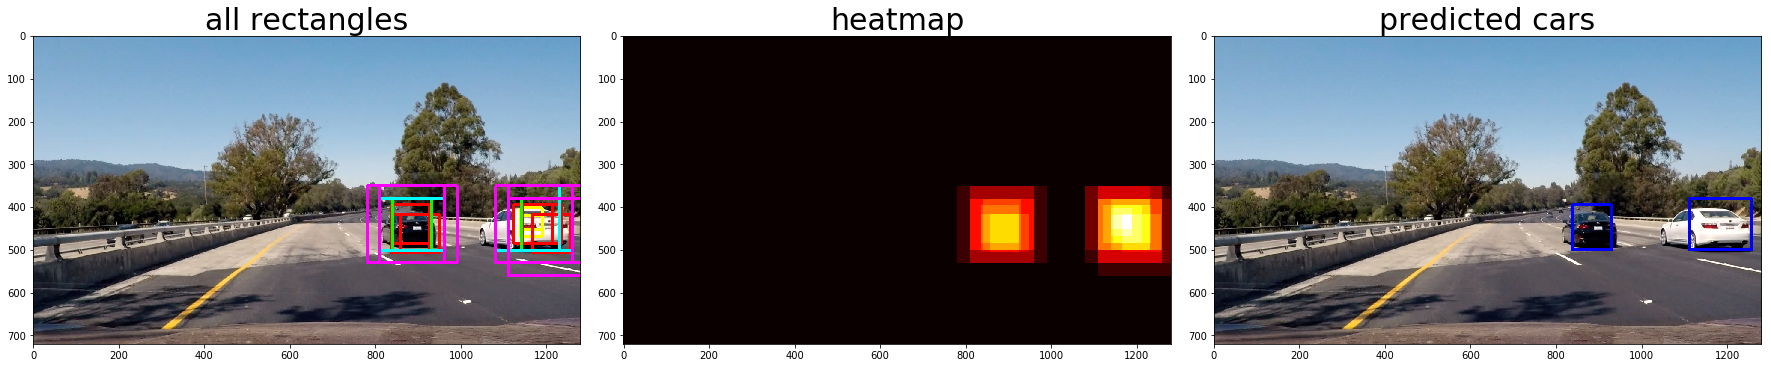

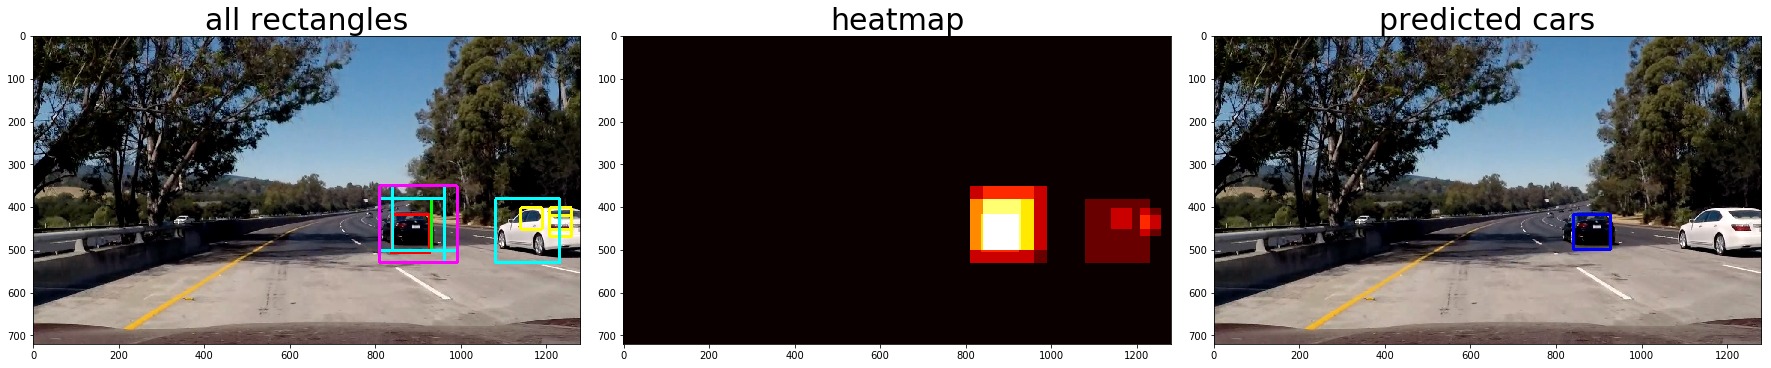

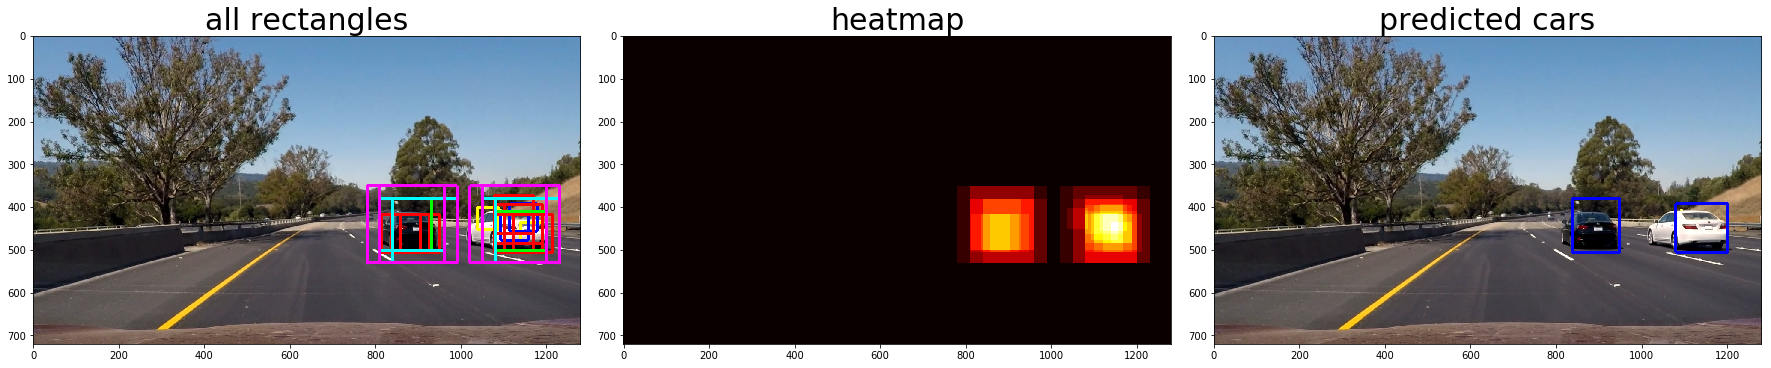

In [18]:
def print_three_images(img1, img2, img3):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))

    f.tight_layout()
    #print("cspace: {0}, channel: {1}".format(color_space, hog_channel))
    ax1.imshow(img1)    
    ax1.set_title("all rectangles", fontsize=30)

    ax2.imshow(img2, cmap = "hot")    
    ax2.set_title("heatmap", fontsize=30)

    ax3.imshow(img3)    
    ax3.set_title("predicted cars", fontsize=30)

    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

predictions.reset()
img = mpimg.imread('test_images/test1.jpg')
img_rect, img_heatmap, res_img = predict_car_positions(img)
print_three_images(img_rect, img_heatmap, res_img)

predictions.reset()
img = mpimg.imread('test_images/test2.jpg')
img_rect, img_heatmap, res_img = predict_car_positions(img)
print_three_images(img_rect, img_heatmap, res_img)

predictions.reset()
img = mpimg.imread('test_images/test3.jpg')
img_rect, img_heatmap, res_img = predict_car_positions(img)
print_three_images(img_rect, img_heatmap, res_img)

predictions.reset()
img = mpimg.imread('test_images/test4.jpg')
img_rect, img_heatmap, res_img = predict_car_positions(img)
print_three_images(img_rect, img_heatmap, res_img)

predictions.reset()
img = mpimg.imread('test_images/test5.jpg')
img_rect, img_heatmap, res_img = predict_car_positions(img)
print_three_images(img_rect, img_heatmap, res_img)

predictions.reset()
img = mpimg.imread('test_images/test6.jpg')
img_rect, img_heatmap, res_img = predict_car_positions(img)
print_three_images(img_rect, img_heatmap, res_img)

On test images it looks not so bad. The model gives lots of false positives, but I filter them out on the heatmap. It's time to apply it on video pipeline!

In [19]:
def pipeline(img):
    img_rect, img_heatmap, res_img = predict_car_positions(img, heatmap_threshold = 30)
    
    # add rectangles and heatmap on the mage
    rect_res = cv2.resize(img_rect, (256, 144))
    heatmap_res = cv2.resize(img_heatmap, (256, 144))
    res_img[20:20 + rect_res.shape[0],20:20 + rect_res.shape[1]] = rect_res
    
    heatmap_res2 = np.rint(heatmap_res*256/np.amax(heatmap_res))    
    heatmap_res2[heatmap_res2 > 255] = 255
    res_img[20:20 + heatmap_res2.shape[0],300:300 + heatmap_res2.shape[1],0] = heatmap_res2
    res_img[20:20 + heatmap_res2.shape[0],300:300 + heatmap_res2.shape[1],1] = 0
    res_img[20:20 + heatmap_res2.shape[0],300:300 + heatmap_res2.shape[1],2] = 0
 
    return res_img

## Render videos
### Render sample videos

In [ ]:
predictions.reset()
predictions.stack_size = 60

fname = 'test_video.mp4'
white_output = 'test_videos_output/' + fname
clip1 = VideoFileClip(fname)
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
white_clip.write_videofile(white_output, audio=False)

In [ ]:
predictions.reset()
predictions.stack_size = 60

fname = 'project_video.mp4'
white_output = 'test_videos_output/' + fname
clip1 = VideoFileClip(fname)
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
white_clip.write_videofile(white_output, audio=False)

# Summary

My pipeline is able to detect cars on given images, but it still could be improved:
1. First of all, quality of the model should be improved. Current model gives lots of false positives and probably I should use different model (not support vector machines), or extend train dataset, or use different features from the image to detect. I was able to filter out false positive results on video by stacking of the rectangles, but it also filters out cars that are far away (you can see it on the video: sometimes car is on the heatmap, but is not detected).
2. Speed of recognition could be improved. I think sliding window function could be called on less amount of places and sizes, and probably features vector could be optimized as well. Or I can use just another model that will work faster.
3. Most of the train images contains cars from the back with small angle. But on the video we saw cars from 60-45 degree angle. Train datased should be extended with cars from different perspective.
4. My model will probably fail on cars that goes in opposite direction (which may be dangerous).
5. My pipeline will probably fail in night and dark conditions, it may fail even in a tonnel. 
From my perspective vehicle detection should be done on sensor level — it will be probably faster, more robust and safer.